<a href="https://colab.research.google.com/github/hishhh/kaggle-api/blob/master/TF_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=VtRLrQ3Ev-U 

10:00

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf 
import tensorflow_hub as hub 

In [3]:
df = pd.read_csv("wine-reviews.csv", usecols = ["country", "description", "points", "price", "variety", "winery"])

In [4]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87.0,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87.0,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87.0,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87.0,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87.0,65.0,Pinot Noir,Sweet Cheeks


In [5]:
df = df.dropna(subset=["description", "points"])

In [6]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87.0,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87.0,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87.0,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87.0,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87.0,65.0,Pinot Noir,Sweet Cheeks


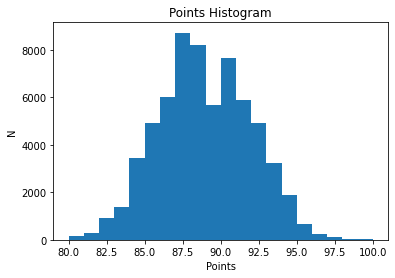

In [7]:
plt.hist(df.points, bins=20)
plt.title("Points Histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [8]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [9]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [10]:
len(train), len(val), len(test)

(51565, 6446, 6446)

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

Embedding + Model

In [13]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [14]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.47963905, -0.16675515,  0.02122821, ..., -0.04152861,
        -0.09615687, -0.00361019],
       [ 0.57734835, -0.37139496, -0.10748321, ...,  0.1841566 ,
        -0.00406148, -0.05984489],
       [ 0.4847633 , -0.20524307, -0.00792111, ...,  0.12116245,
        -0.14963418,  0.02326758],
       ...,
       [ 0.34524012, -0.28197545,  0.01132466, ..., -0.02854653,
        -0.10839764,  0.01790555],
       [ 0.42965102, -0.16445684, -0.14094403, ...,  0.04084659,
         0.0324171 , -0.10218275],
       [ 0.37335792,  0.0827638 ,  0.03380953, ..., -0.08305024,
        -0.27516532,  0.1262914 ]], dtype=float32)>

In [15]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [17]:
model.evaluate(train_data)

51/51 [==============================] - 1s 9ms/step - loss: 0.6913 - accuracy: 0.5211


[0.6912850141525269, 0.5210704803466797]

In [18]:
model.evaluate(valid_data)

7/7 [==============================] - 0s 8ms/step - loss: 0.6906 - accuracy: 0.5307


[0.6906042098999023, 0.5307167172431946]

In [19]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
51/51 [==============================] - 12s 226ms/step - loss: 0.6565 - accuracy: 0.6069 - val_loss: 0.6148 - val_accuracy: 0.6137
Epoch 2/5
51/51 [==============================] - 13s 250ms/step - loss: 0.5733 - accuracy: 0.6912 - val_loss: 0.4974 - val_accuracy: 0.7771
Epoch 3/5
51/51 [==============================] - 15s 296ms/step - loss: 0.4719 - accuracy: 0.7802 - val_loss: 0.4273 - val_accuracy: 0.8052
Epoch 4/5
51/51 [==============================] - 12s 241ms/step - loss: 0.4128 - accuracy: 0.8240 - val_loss: 0.4055 - val_accuracy: 0.8162
Epoch 5/5
51/51 [==============================] - 12s 238ms/step - loss: 0.3719 - accuracy: 0.8497 - val_loss: 0.3996 - val_accuracy: 0.8183


In [20]:
model.evaluate(test_data)

7/7 [==============================] - 0s 28ms/step - loss: 0.3983 - accuracy: 0.8185


[0.3983420431613922, 0.8184921145439148]

LSTM

In [21]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [22]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'to', 'it', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [25]:
model.evaluate(train_data)
model.evaluate(valid_data)

7/7 [==============================] - 1s 97ms/step - loss: 0.6938 - accuracy: 0.4055


[0.6937944889068604, 0.40552279353141785]

In [26]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
51/51 [==============================] - 20s 325ms/step - loss: 0.6435 - accuracy: 0.6257 - val_loss: 0.5540 - val_accuracy: 0.7298
Epoch 2/5
51/51 [==============================] - 15s 292ms/step - loss: 0.4450 - accuracy: 0.8026 - val_loss: 0.3822 - val_accuracy: 0.8280
Epoch 3/5
51/51 [==============================] - 16s 306ms/step - loss: 0.3699 - accuracy: 0.8369 - val_loss: 0.3726 - val_accuracy: 0.8328
Epoch 4/5
51/51 [==============================] - 15s 292ms/step - loss: 0.3498 - accuracy: 0.8482 - val_loss: 0.3660 - val_accuracy: 0.8323
Epoch 5/5
51/51 [==============================] - 16s 317ms/step - loss: 0.3384 - accuracy: 0.8529 - val_loss: 0.3650 - val_accuracy: 0.8328


In [27]:
model.evaluate(test_data)

7/7 [==============================] - 1s 92ms/step - loss: 0.3547 - accuracy: 0.8422


[0.3547227680683136, 0.8422277569770813]